In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp

In [2]:
# Define the function to read OMG CSV data based on the provided function
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns += ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns += ['BUTTON']
        
    if sync_ch:
        columns += ['SYNC']
        
    if timestamp_ch:
        columns += ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Paths to the .palm files
palm_files = [
    "data/2023-05-05_17-57-30.palm",
    "data/2023-05-07_15-19-05.palm",
    "data/2023-05-07_16-54-27.palm",
    "data/2023-05-12_19-17-00.palm"
]

# Parameters for reading the files
params = {
    "n_omg_channels": 50,
    "n_acc_channels": 3,
    "n_gyr_channels": 3,
    "n_enc_channels": 6,
    "n_mag_channels": 0,
    "button_ch": True,
    "sync_ch": True,
    "timestamp_ch": True
}

# Read each palm file and store the data in a dictionary
gestures_data = {}
for path in palm_files:
    file_id = path.split('/')[-1].split('.')[0]  # Extracting file id from the filename
    gestures_data[f"gestures_{file_id}"] = read_omg_csv(path, **params)

# Output the keys of the dictionary to confirm data loading
gestures_data.keys()

dict_keys(['gestures_2023-05-05_17-57-30', 'gestures_2023-05-07_15-19-05', 'gestures_2023-05-07_16-54-27', 'gestures_2023-05-12_19-17-00'])

In [3]:
# Paths to the .palm.protocol.csv files
protocol_files = [
    "data/2023-05-05_17-57-30.palm.protocol.csv",
    "data/2023-05-07_15-19-05.palm.protocol.csv",
    "data/2023-05-07_16-54-27.palm.protocol.csv",
    "data/2023-05-12_19-17-00.palm.protocol.csv"
]

# Read each protocol file and store the data in a dictionary
gestures_protocol_data = {}
for path in protocol_files:
    file_id = path.split('/')[-1].split('.palm')[0]  # Extracting file id from the filename
    df_protocol = pd.read_csv(path)
    le = LabelEncoder()
    
    # FIT
    le.fit(
        df_protocol[[
            "Thumb","Index","Middle","Ring","Pinky",
            'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
        ]]
        .apply(lambda row: str(tuple(row)), axis=1)
    )

    # TRANSFORM
    df_protocol['gesture'] = le.transform(
        df_protocol[[
            "Thumb","Index","Middle","Ring","Pinky",
            'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
        ]]
        .apply(lambda row: str(tuple(row)), axis=1)
    )

    gestures_protocol_data[f"gestures_protocol_{file_id}"] = df_protocol

# Output the keys of the dictionary to confirm data loading
gestures_protocol_data.keys()

dict_keys(['gestures_protocol_2023-05-05_17-57-30', 'gestures_protocol_2023-05-07_15-19-05', 'gestures_protocol_2023-05-07_16-54-27', 'gestures_protocol_2023-05-12_19-17-00'])

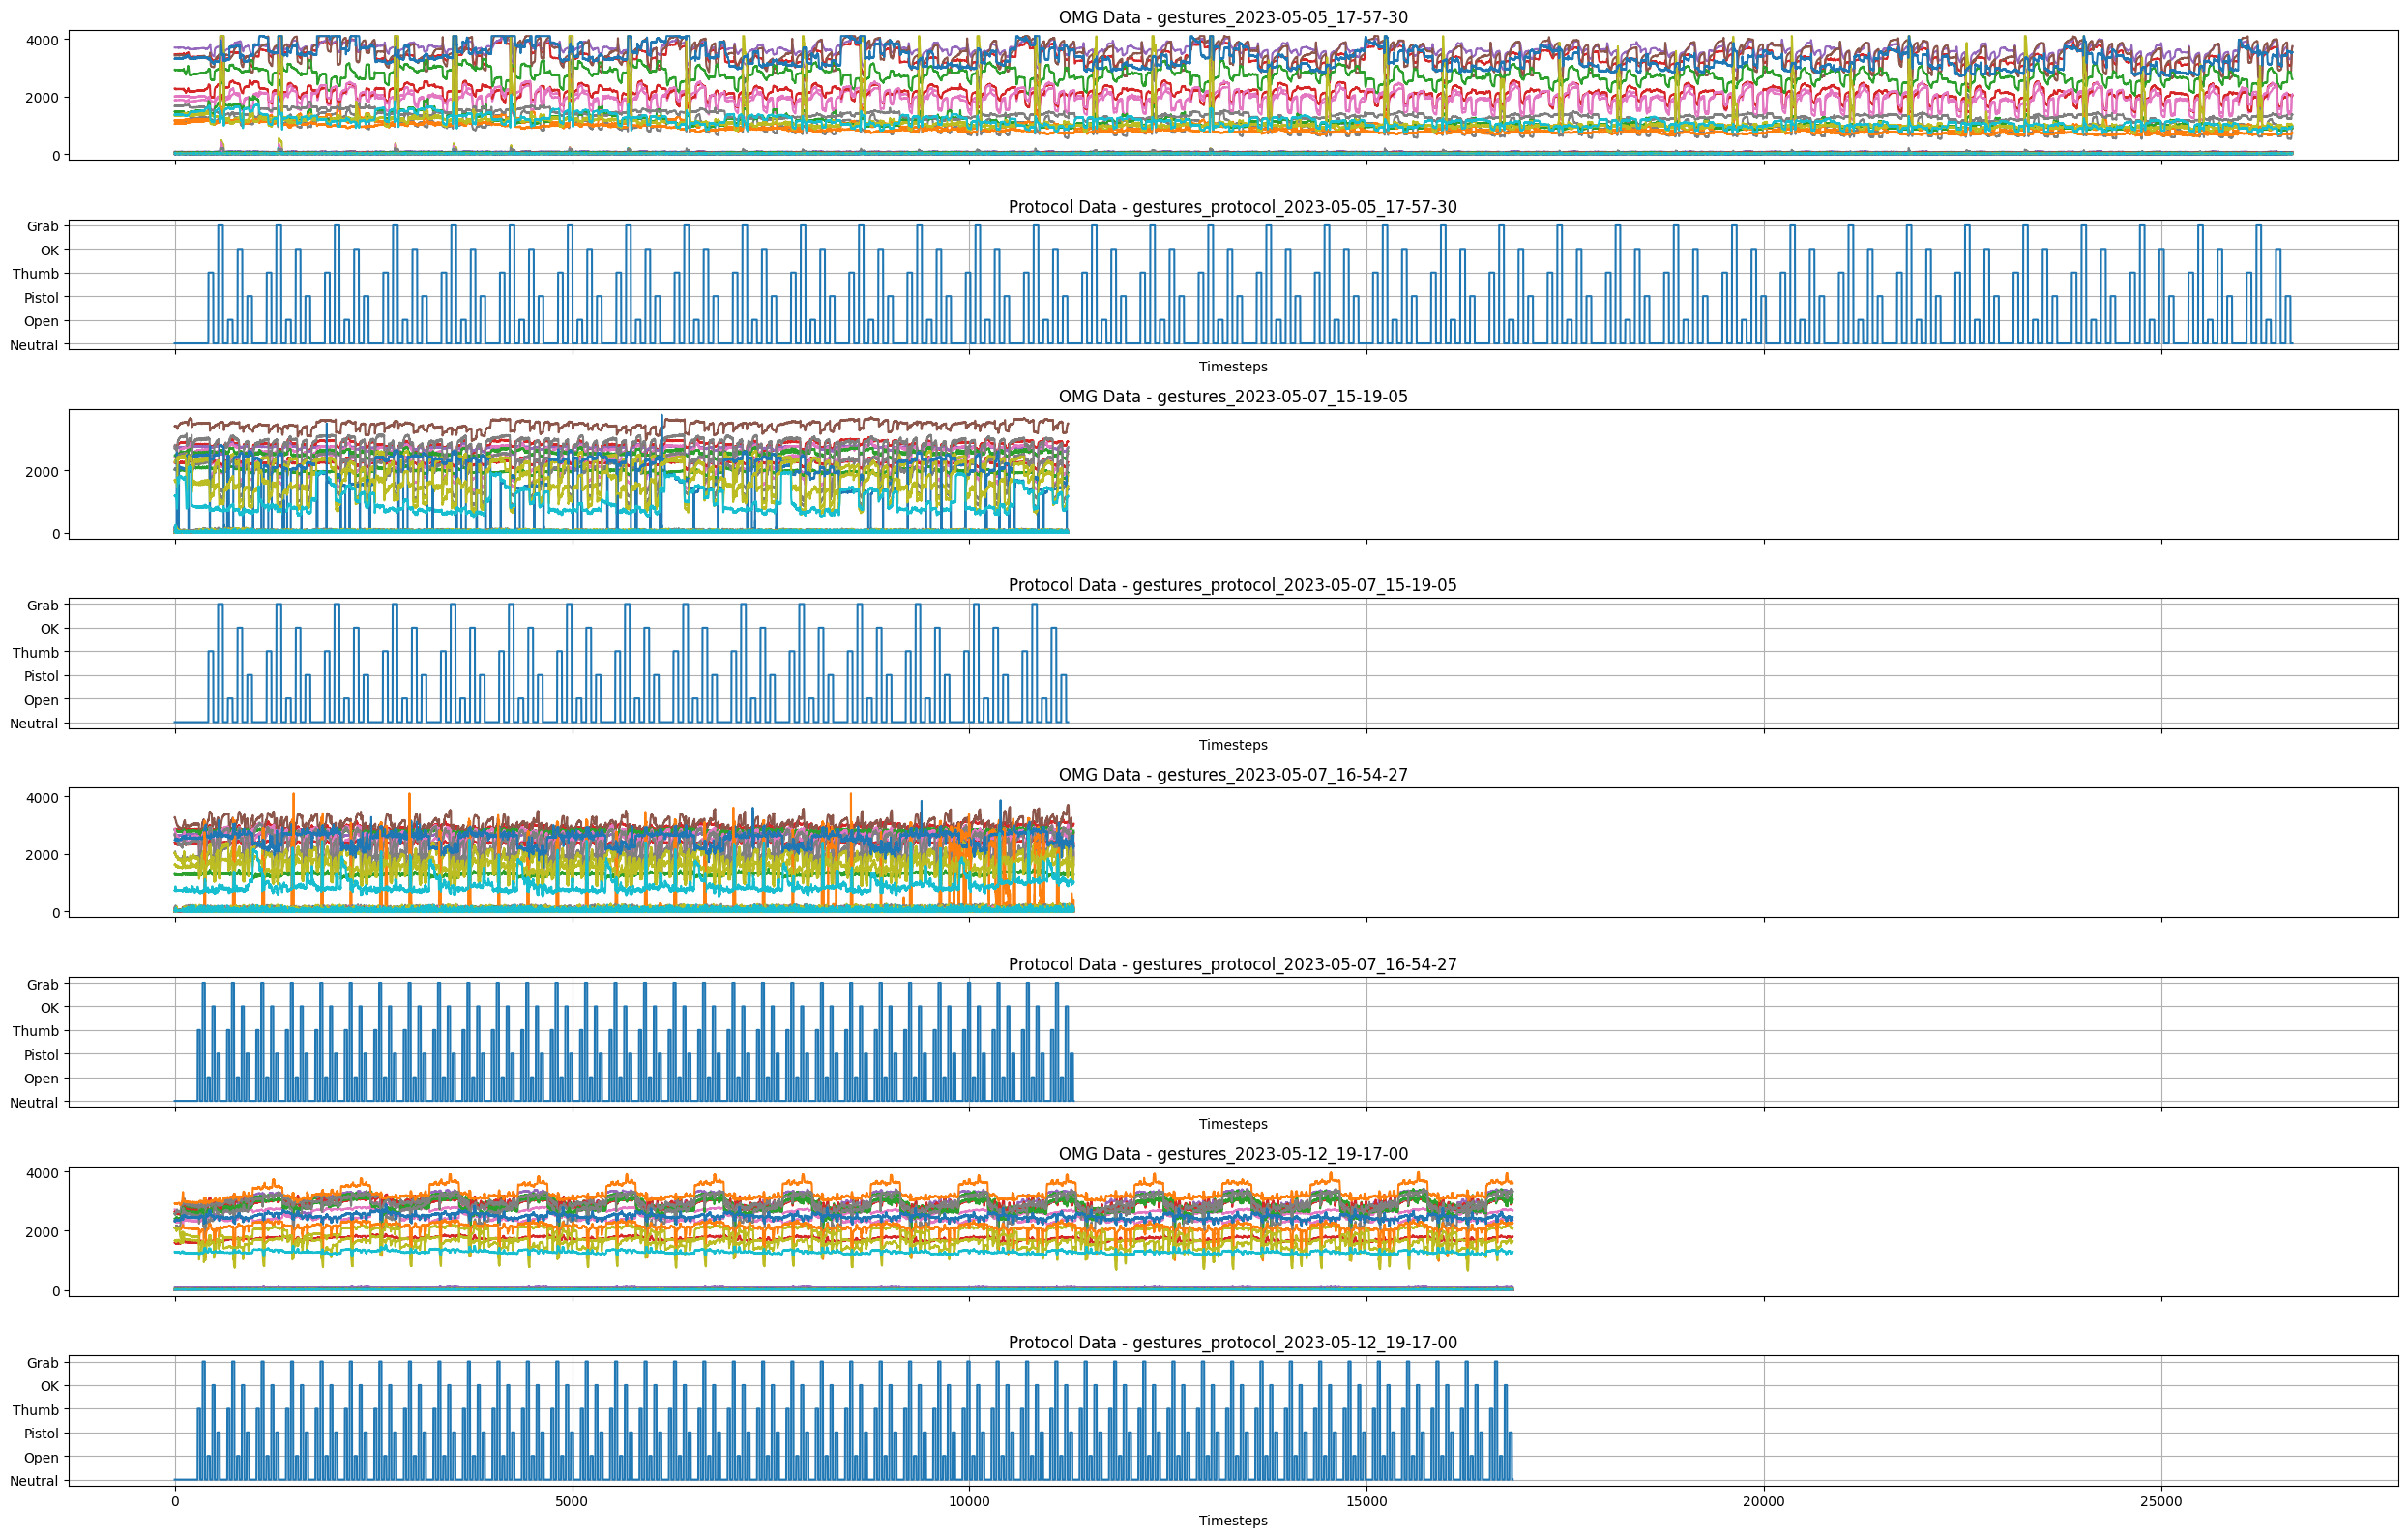

In [4]:
# Generate plots for all keys in the gestures and gestures_protocol dictionaries correctly

# OMG channel names (example, assuming first 50 channels are OMG related)
OMG_CH = [str(i) for i in range(50)]
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

# Number of dataset pairs
num_datasets = len(gestures_data)

# Create a large enough figure to accommodate all subplots
fig, axes = plt.subplots(num_datasets * 2, 1, sharex=True, figsize=(25, 4 * num_datasets))
if num_datasets == 1:
    axes = [axes]  # Make sure axes are iterable

# Loop through each dataset and plot both OMG and protocol data
for idx, (gestures_key, gestures_protocol_key) in enumerate(zip(gestures_data.keys(), gestures_protocol_data.keys())):
    gestures = gestures_data[gestures_key]
    gestures_protocol = gestures_protocol_data[gestures_protocol_key]

    # Create array of gesture commands based on 'SYNC' values from gestures
    y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

    # OMG Data Plot
    ax_omg = axes[2 * idx]  # Even index for OMG
    ax_omg.plot(gestures[OMG_CH].values)
    ax_omg.set_title(f'OMG Data - {gestures_key}')

    # Protocol Data Plot
    ax_protocol = axes[2 * idx + 1]  # Odd index for protocol
    ax_protocol.plot(y_cmd)
    ax_protocol.grid()
    ax_protocol.set_yticks(np.arange(len(GESTURES)))
    ax_protocol.set_yticklabels(GESTURES)
    ax_protocol.set_xlabel('Timesteps')
    ax_protocol.set_title(f'Protocol Data - {gestures_protocol_key}')

plt.tight_layout()
plt.show()

In [5]:

# Update the gestures list with names for labeling
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

# Create a Plotly figure with multiple subplots
fig = sp.make_subplots(rows=num_datasets * 2, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Loop through each dataset and plot both OMG and protocol data
for idx, (gestures_key, gestures_protocol_key) in enumerate(zip(gestures_data.keys(), gestures_protocol_data.keys())):
    gestures = gestures_data[gestures_key]
    gestures_protocol = gestures_protocol_data[gestures_protocol_key]

    # Create array of gesture commands based on 'SYNC' values from gestures
    y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

    # OMG Data Traces for all channels
    for channel in OMG_CH:
        fig.add_trace(
            go.Scatter(
                x=np.arange(len(gestures[channel].values)),
                y=gestures[channel].values,
                mode='lines',
                showlegend=False,  # Disable legend for individual traces
                name=f'Channel {channel}'  # Label for hover info
            ),
            row=2 * idx + 1, col=1
        )
    
    # Add subplot titles for OMG data
    # fig.add_annotation(
    #     text=f'OMG Data - {gestures_key}',
    #     xref='paper', yref='paper',
    #     x=0.5, y=1 - (0.6/ (num_datasets * 2)) * (2 * idx + 0.5),
    #     showarrow=False,
    #     font=dict(size=14, color='green'),
    #     align='center',
    #     xanchor='center',
    #     yanchor='bottom'
    # )

    # Protocol Data Trace
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(y_cmd)),
            y=y_cmd,
            mode='lines',
            showlegend=False,  # Disable legend for individual traces
            name=f'Protocol - {gestures_protocol_key}'  # Label for hover info
        ),
        row=2 * idx + 2, col=1
    )

    # Update y-axis to have gesture names for protocol plots
    fig.update_yaxes(
        tickmode='array',
        tickvals=np.arange(len(GESTURES)),
        ticktext=GESTURES,
        row=2 * idx + 2, col=1
    )

    # Add subplot titles for Protocol data
    # fig.add_annotation(
    #     text=f'Protocol Data - {gestures_protocol_key}',
    #     xref='paper', yref='paper',
    #     x=0.5, y=1 - (0.5 / (num_datasets * 2)) * (2 * idx + 1.5),
    #     showarrow=False,
    #     font=dict(size=14, color='red'),
    #     align='center',
    #     xanchor='center',
    #     yanchor='bottom'
    # )

# Update layout to accommodate all subplots with proper titling and axis labels
fig.update_layout(
    height=800 * num_datasets,  # Increased height to better display multiple channels
    title_text="Detailed OMG and Protocol Data Visualization",
    showlegend=False  # Ensure no legend is shown
)

# Show figure
fig.show()
fig.write_html('visualizations/OMG_protocols_visualisations.html')